#Importing essential Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler

from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_path = '/content/drive/MyDrive/DL/Datasets/Faces'

image_data = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
for img in filenames:
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)
  
  new_image = cv2.cvtColor(image_arr,  cv2.COLOR_BGR2RGB)
  image_data.append(new_image)
  
images = np.array(image_data)
print("Size of image array: ", images.shape)

Loading Training Images...
Size of image array:  (4300, 128, 128, 3)


In [4]:
save_path = '/content/drive/MyDrive/DL/Datasets/faces_colour.npy'
np.save(save_path, images)

In [3]:
load_path = '/content/drive/MyDrive/DL/Datasets/faces_color.npy'  #created in local pc as google drive was crashing because the o of images were quiet high
images = np.load(load_path)

In [4]:
print("shape of Loaded array: ", images.shape)

shape of Loaded array:  (36378, 128, 128, 3)


##Visualizing some images

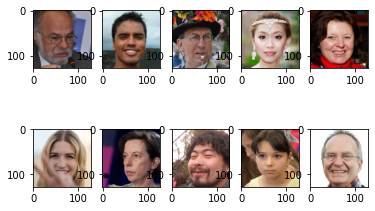

In [5]:
plt.figure(1)
plt.subplot(2,5,1)
plt.imshow(images[15])
plt.subplot(2,5,2)
plt.imshow(images[16])
plt.subplot(2,5,3)
plt.imshow(images[100])
plt.subplot(2,5,4)
plt.imshow(images[200])
plt.subplot(2,5,5)
plt.imshow(images[300])
plt.subplot(2,5,6)
plt.imshow(images[400])
plt.subplot(2,5,7)
plt.imshow(images[500])
plt.subplot(2,5,8)
plt.imshow(images[600])
plt.subplot(2,5,9)
plt.imshow(images[700])
plt.subplot(2,5,10)
plt.imshow(images[800])
plt.show()

## Doing some preprocessing

In [6]:
#Checking if gpu is available
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [7]:
images = np.array(images[0:25000], dtype= np.float32)
images = images/ 255.0

In [8]:
#Moving images to DEVICE
images = torch.tensor(images, device= DEVICE)
print(images.dtype)

torch.float32


In [9]:
images_vec = images.reshape(images.shape[0], -1)

In [10]:
print("shape of image after flattening them: ", images_vec.shape)

shape of image after flattening them:  torch.Size([25000, 49152])


In [11]:
back = images_vec.reshape(-1, 128, 128, 3)

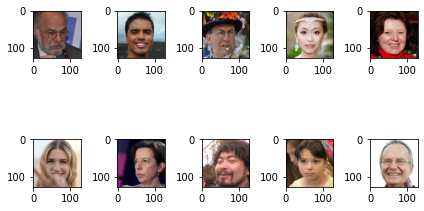

In [12]:
#Reshaping the flattened arrays to get back the images
plt.figure(1)
plt.subplot(2,5,1)
plt.imshow(back[15].cpu().numpy())
plt.subplot(2,5,2)
plt.imshow(back[16].cpu().numpy())
plt.subplot(2,5,3)
plt.imshow(back[100].cpu().numpy())
plt.subplot(2,5,4)
plt.imshow(back[200].cpu().numpy())
plt.subplot(2,5,5)
plt.imshow(back[300].cpu().numpy())
plt.subplot(2,5,6)
plt.imshow(back[400].cpu().numpy())
plt.subplot(2,5,7)
plt.imshow(back[500].cpu().numpy())
plt.subplot(2,5,8)
plt.imshow(back[600].cpu().numpy())
plt.subplot(2,5,9)
plt.imshow(back[700].cpu().numpy())
plt.subplot(2,5,10)
plt.imshow(back[800].cpu().numpy())
plt.tight_layout()
plt.show()

#Creating Network Architecture

credits: Professor [Justin Johnson](https://web.eecs.umich.edu/~justincj/)

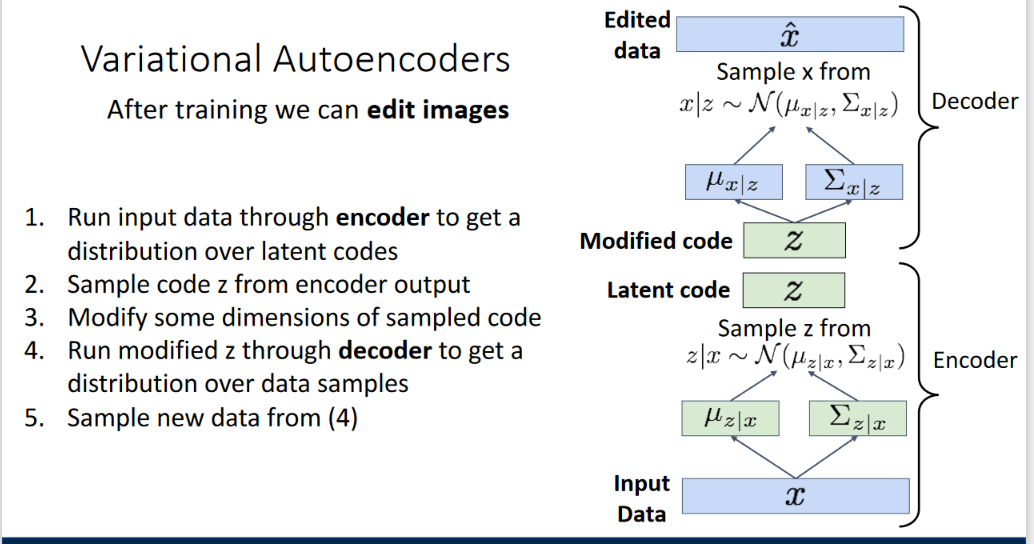

In [13]:
class Variational_Autoencoders(nn.Module):

  def __init__(self,input_dims, hidden_dims, z_shape ):     #Features is the dimension of Height and Width of the image
    super(Variational_Autoencoders, self).__init__()

    #Encoder Network
    self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
        )
    
    #sapearte fully connected layer for mean. we will sample from mean and covariance to form the vector z which will go as input to decoder neywork
    self.mean_layer = nn.Linear(hidden_dims, z_shape)

    #sapearte fully connected layer for covariance
    self.log_covariance_layer = nn.Linear(hidden_dims, z_shape)

    #Decoder Network
    self.decoder = nn.Sequential(
            nn.Linear(z_shape, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dims, input_dims),
            nn.Sigmoid(),                           #we use sigmoid when we use binary cross entropy loss
            #nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )
    
  def forward(self, input):   #input has shape(N, 784)

    #Passing through encoder network:
    out = self.encoder(input)

    out_mean = self.mean_layer(out)

    out_logcov = self.log_covariance_layer(out)

    #sampling from normal distribution with mean= out_mean and log covariance = out_logcov

    sigma = torch.sqrt(torch.exp(out_logcov))
    z = sigma * torch.randn_like(out_mean) + out_mean

    #Passing through decoder network:
    out = self.decoder(z)
  
    return out, out_mean, out_logcov



In [14]:
vae = Variational_Autoencoders(input_dims = images_vec.shape[1], hidden_dims = 500, z_shape = 20).to(device= DEVICE)

In [15]:
#Doing a forward pass through the network:
out, a, b = vae(images_vec[0:5])

In [16]:
out.shape

torch.Size([5, 49152])

#Model Training:

In [29]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)        #update the weights of the network vae
loss_type = nn.BCELoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 2000, gamma = 0.5)  

In [30]:
#Model Training
loss_graph = []
num_epochs = 10000
num_train = images_vec.shape[0]
batch_size = 200
vae.train()
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images_vec[random_no]
  
  optimizer.zero_grad()
  y_pred, out_mean, out_logcov = vae(x_batch)

  y1 = nn.functional.binary_cross_entropy(y_pred, x_batch, reduction='sum')

  y1_ = 1 + out_logcov - out_mean**2 - torch.exp(out_logcov)
  y1_ = -0.5 * y1_.sum()
  loss = y1 + y1_
  loss /= out_mean.shape[0]
  loss.backward()
  optimizer.step()

  #schedular step
  step_lr.step()

  loss_graph.append(loss.cpu().item())
  if i%1500==0:
    print("Epoch: ", i+1, ", loss is: ", loss.cpu().item())
    #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])

Epoch:  1 , loss is:  29546.875
Epoch:  1501 , loss is:  29378.857421875
Epoch:  3001 , loss is:  29318.603515625
Epoch:  4501 , loss is:  29318.31640625
Epoch:  6001 , loss is:  29089.240234375
Epoch:  7501 , loss is:  29270.4609375
Epoch:  9001 , loss is:  29070.189453125


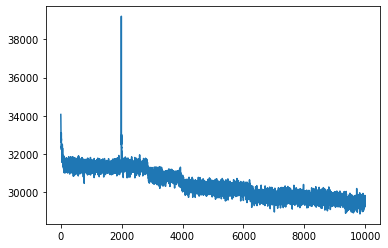

In [19]:
#Loss Curve
#Loss Graph
plt.plot(loss_graph)
plt.show()

In [31]:
vae.eval()
out, a, b = vae(images_vec[0:5])

Actual output: 


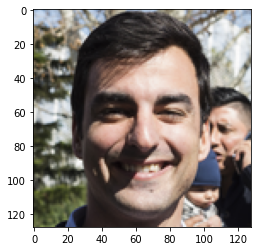

Output from the model: 


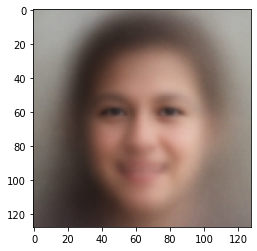

In [32]:
print("Actual output: ")
plt.imshow(images[3].cpu().numpy(), cmap= 'gray')
plt.show()

print("Output from the model: ")
plt.imshow(out[3].reshape(128,128,3).detach().cpu().numpy(), cmap= 'gray')
plt.show()

we can see that the model is able to somewhat replicate the input so now we can use the vector z (sample from mean and logcov) to produce different outputs

In [33]:
def generate_images(input):
  out = vae.decoder(input)
  return out

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


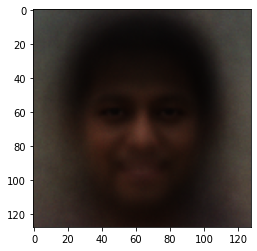

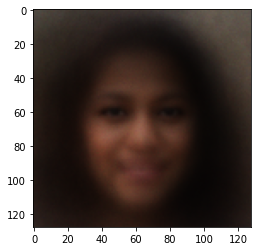

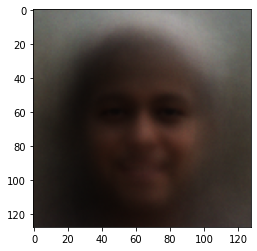

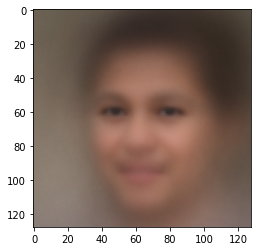

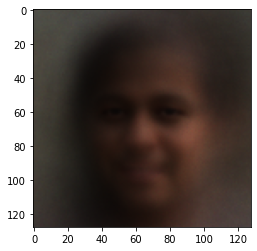

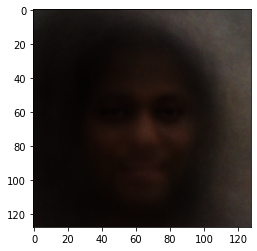

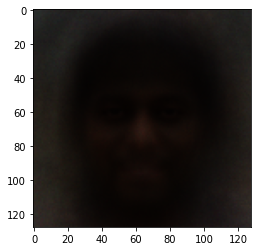

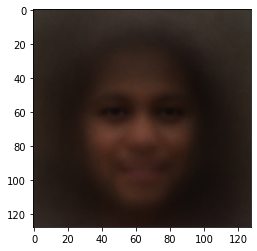

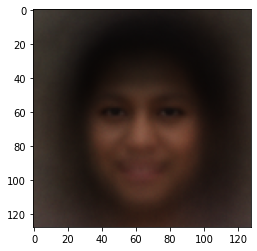

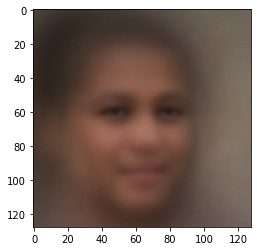

In [34]:
z = torch.randn(10, 20)  #displaying 10 samples 
z = torch.tensor(z, device = DEVICE, dtype = torch.float32)

for i in range(z.shape[0]):
  img_out = generate_images(z)
  plt.imshow(img_out[i].reshape(128,128,3).detach().cpu().numpy(), cmap= 'gray')
  plt.show()
